# Simuler une loi multinomiale

On part d'une loi uniforme et on simule une loi multinomiale.

In [12]:
%matplotlib inline

Une variable qui suit une [loi multinomiale](http://fr.wikipedia.org/wiki/Loi_multinomiale) est une variable à valeurs entières qui prend ses valeurs dans un ensemble fini, et chacune de ces valeurs a une probabilité différente.

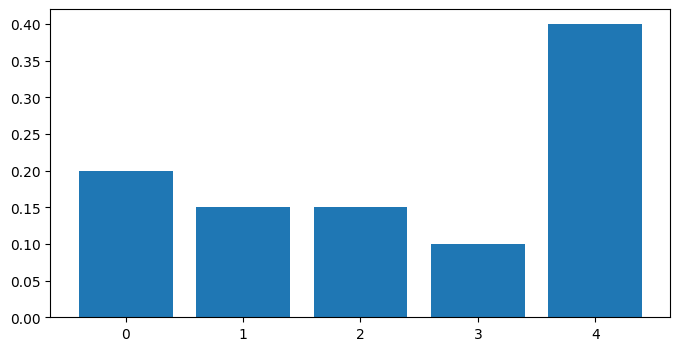

In [13]:
import matplotlib.pyplot as plt

poids = [0.2, 0.15, 0.15, 0.1, 0.4]
valeur = [0, 1, 2, 3, 4]
plt.figure(figsize=(8, 4))
plt.bar(valeur, poids);

Lorsqu'on simule une telle loi, chaque valeur a une probabilité de sortir proportionnelle à chaque poids. La fonction [numpy.random.multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html) permet de calculer cela.

In [14]:
import numpy.random as rnd

draw = rnd.multinomial(1000, poids)
draw / sum(draw)

array([0.199, 0.162, 0.129, 0.105, 0.405])

Pour avoir 1000 tirages plutôt que l'aggrégation des 1000 tirages :

In [15]:
draw = rnd.multinomial(1, poids, 1000)
draw

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

### Algorithme de simulation

Tout d'abord, on calcule la distribution cumulée (ou [fonction de répartition](http://fr.wikipedia.org/wiki/Fonction_de_r%C3%A9partition)). Le calcule proposé utilise la fonction [numpy.cumsum](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html).

[0.2  0.35 0.5  0.6  1.  ]


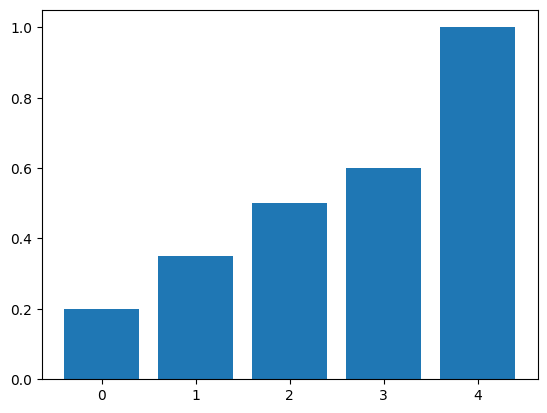

In [16]:
import numpy

cum = numpy.cumsum(
    poids
)  # voir http://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html
print(cum)
plt.bar(valeur, cum);

Cette fonction de répartition $(x,F(x))$ est croissante. On définit les cinq intervalles : $A_i=]F(i),F(i+1)]$. Pour simuler une loi multinomiale, il suffit de tirer un nombre aléatoire dans $[0,1]$ puis de trouver l'intervalle $A_i$ auquel il appartient. $i$ est le résultat cherché. Le calcul de la distribution cumulée utilise une autre alternative : [functools.reduce](https://docs.python.org/3.4/library/functools.html#functools.reduce).

In [17]:
import functools, random


def simulation_multinomiale(poids):
    # calcule la fonction de répartition
    # voir https://docs.python.org/3.4/library/functools.html#functools.reduce
    def agg(x, y):
        x.append(y)
        return x

    cum = functools.reduce(agg, poids, [])

    x = random.random()
    s = 0
    i = 0
    while s <= x and i < len(cum):
        s += cum[i]
        i += 1
    return i - 1


alea = [simulation_multinomiale(poids) for i in range(0, 1000)]
alea[:10]

[4, 1, 4, 4, 0, 0, 4, 2, 2, 4]

On vérifie que les probabilités d'apparition de chaque nombre sont celles attendues.

In [18]:
import collections

c = collections.Counter(alea)
c

Counter({4: 430, 0: 177, 2: 156, 1: 139, 3: 98})

### Une première optimisation : tri des poids

L'algorithme fait intervenir le calcul de la distribution cumulée. Lorsqu'on tire un grand nombre de variable aléatoire, il est intéressant de ne faire ce calcul qu'une seule fois puisqu'il ne change jamais. De même, il est plus intéressant de mettre les valeurs de plus grand poids en premier. La boucle de la fonction ``simulation_multinomiale`` s'arrêtera plus tôt.

In [19]:
def simulation_multinomiale(pc):
    x = random.random()
    s = 0
    i = 0
    while s <= x and i < len(pc):
        s += pc[i]
        i += 1
    return i - 1


def agg(x, y):
    x.append(y)
    return x


poids_cumule = functools.reduce(agg, poids, [])
poids_cumule_trie = functools.reduce(agg, sorted(poids, reverse=True), [])
print(poids_cumule, poids_cumule_trie)

import time

for p in range(0, 3):
    print("passage", p)
    a = time.perf_counter()
    alea = [simulation_multinomiale(poids_cumule) for i in range(0, 10000)]
    b = time.perf_counter()
    print("  non trié", b - a)
    a = time.perf_counter()
    alea = [simulation_multinomiale(poids_cumule_trie) for i in range(0, 10000)]
    b = time.perf_counter()
    print("  trié", b - a)

[0.2, 0.15, 0.15, 0.1, 0.4] [0.4, 0.2, 0.15, 0.15, 0.1]
passage 0
  non trié 0.009419400001206668
  trié 0.007181299999501789
passage 1
  non trié 0.010566299999481998
  trié 0.0066910000023199245
passage 2
  non trié 0.007558699999208329
  trié 0.006804499997087987


La seconde version est plus rapide.Son intérêt dépend du nombre d'observations aléatoire à tirer. En effet, si $K$ est le nombre de valeurs distinctes, les coûts fixes des deux méthodes sont les suivants :

- non trié : $O(K)$ (distribution cumulative)
- trié : $O(K + K\ln K)$ ((distribution cumulative + tri)

Qu'en est-il pour la fonction [numpy.random.multinomial](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html#numpy.random.multinomial) ?

In [20]:
poids_trie = list(sorted(poids, reverse=True))

for p in range(0, 3):
    print("passage", p)
    a = time.perf_counter()
    rnd.multinomial(10000, poids)
    b = time.perf_counter()
    print("  non trié", b - a)
    a = time.perf_counter()
    rnd.multinomial(10000, poids_trie)
    b = time.perf_counter()
    print("  trié", b - a)

passage 0
  non trié 0.00013789999866276048
  trié 0.00010370000018156134
passage 1
  non trié 0.0004912999975204002
  trié 0.00014940000255592167
passage 2
  non trié 6.950000170036219e-05
  trié 0.0002525000018067658


C'est plus rapide aussi. On voit aussi que cette façon de faire est beaucoup plus rapide que la version implémentée en Python pur. Cela vient du faire que le module [numpy](http://www.numpy.org/) est optimisé pour le calcul numérique et surtout implémenté en langages [C++](http://fr.wikipedia.org/wiki/C%2B%2B) et [Fortran](http://fr.wikipedia.org/wiki/Fortran).

### Optimisation bootstrap

C'est une technique inspiré du [bootstrap](http://fr.wikipedia.org/wiki/Bootstrap_%28statistiques%29) qui est un peu moins précise que la version précédente mais qui peut suffire dans bien des cas. Elle est intéressante si on tire un grand nomrbre d'observations aléatoire de la même loi et si $K$ est grand ($K$ = nombre de valeurs distinctes). L'idée consiste à générer un premier grand vecteur de nombres aléatoires puis à tirer des nombres aléatoire dans ce vecteur.

In [21]:
K = 100
poids = [1 / K for i in range(0, K)]
poids_cumule = functools.reduce(agg, poids, [])
vecteur = [simulation_multinomiale(poids_cumule) for i in range(0, 100000)]
N = len(vecteur) - 1

for p in range(0, 3):
    print("passage", p)
    a = time.perf_counter()
    alea = [simulation_multinomiale(poids_cumule) for i in range(0, 10000)]
    b = time.perf_counter()
    print("  simulation_multinomiale", b - a)
    a = time.perf_counter()
    alea = [vecteur[random.randint(0, N)] for i in range(0, 10000)]
    b = time.perf_counter()
    print("  bootstrap", b - a)

passage 0
  simulation_multinomiale 0.06869539999752305
  bootstrap 0.00884070000029169
passage 1
  simulation_multinomiale 0.08114130000103614
  bootstrap 0.0094169999974838
passage 2
  simulation_multinomiale 0.06719900000098278
  bootstrap 0.01211440000042785


Cette façon de faire implique le stockage d'un grand nombre de variables aléatoires dans ``vecteur``. Ce procédé est plus rapide car tirer un nombre aléatoire entier est plus rapide que de simuler une variable de loi multinomial.